d:\Conda\envs\RL_Simple\lib\site-packages\gym\core.py:26: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"
d:\Conda\envs\RL_Simple\lib\site-packages\gym\core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
d:\Conda\envs\RL_Simple\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is rec

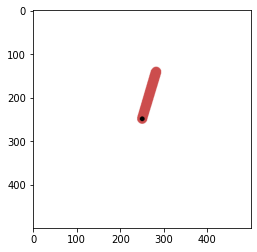

In [1]:
import gym
from matplotlib import pyplot as plt
%matplotlib inline

#创建环境
env = gym.make('Pendulum-v1')
env.reset()


#打印游戏
def show():
    plt.imshow(env.render(mode='rgb_array'))
    plt.show()


show()

In [2]:
import torch

#计算动作的模型,也是真正要用的模型
model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
)

#经验网络,用于评估一个状态的分数
next_model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
)

#把model的参数复制给next_model
next_model.load_state_dict(model.state_dict())

model, next_model

(Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ))

In [3]:
import random


def get_action(state):
    #走神经网络,得到一个动作
    state = torch.FloatTensor(state).reshape(1, 3)
    action = model(state).argmax().item()

    if random.random() < 0.01:
        action = random.choice(range(11))

    #离散动作连续化
    action_continuous = action
    action_continuous /= 10
    action_continuous *= 4
    action_continuous -= 2

    return action, action_continuous


get_action([0.29292667, 0.9561349, 1.0957013])

(2, -1.2)

In [4]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        #初始化游戏
        state = env.reset()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action, action_continuous = get_action(state)

            #执行动作,得到反馈
            next_state, reward, over, _ = env.step([action_continuous])

            #记录数据样本
            datas.append((state, action, reward, next_state, over))

            #更新游戏状态,开始下一个动作
            state = next_state

    update_count = len(datas) - old_count
    drop_count = max(len(datas) - 5000, 0)

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 5000:
        datas.pop(0)

    return update_count, drop_count


update_data(), len(datas)

((200, 0), 200)

In [5]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 3]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
    #[b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 3]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state, action, reward, next_state, over

d:\Conda\envs\RL_Simple\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  import sys


(tensor([[-9.2810e-01,  3.7233e-01,  1.3928e+00],
         [-9.7367e-01,  2.2796e-01,  1.5386e+00],
         [-8.8369e-01,  4.6808e-01,  1.3003e-01],
         [-9.1114e-01,  4.1210e-01,  9.7173e-01],
         [-9.7445e-01,  2.2461e-01,  1.4201e+00],
         [-8.2253e-01,  5.6873e-01,  3.0522e-01],
         [-9.8746e-01,  1.5786e-01,  1.4138e+00],
         [-9.8865e-01, -1.5023e-01,  4.3328e-01],
         [-9.9963e-01,  2.7273e-02,  1.2317e+00],
         [-9.9167e-01, -1.2878e-01,  7.0987e-01],
         [-8.9400e-01,  4.4807e-01, -1.3145e+00],
         [-9.7598e-01,  2.1786e-01, -1.2316e+00],
         [-8.7086e-01,  4.9152e-01,  6.2119e-01],
         [-8.4802e-01,  5.2996e-01, -1.6237e-01],
         [-9.8878e-01, -1.4941e-01, -1.5728e-01],
         [-9.5939e-01,  2.8209e-01, -1.1231e+00],
         [-9.5232e-01,  3.0511e-01, -1.4167e+00],
         [-9.9802e-01, -6.2958e-02, -6.8337e-01],
         [-8.7831e-01,  4.7809e-01, -1.1300e+00],
         [-8.1248e-01,  5.8298e-01, -2.7068e-01],


In [6]:
def get_value(state, action):
    #使用状态计算出动作的logits
    #[b, 3] -> [b, 11]
    value = model(state)

    #根据实际使用的action取出每一个值
    #这个值就是模型评估的在该状态下,执行动作的分数
    #在执行动作前,显然并不知道会得到的反馈和next_state
    #所以这里不能也不需要考虑next_state和reward
    #[b, 11] -> [b, 1]
    value = value.gather(dim=1, index=action)

    return value


get_value(state, action)

tensor([[0.4603],
        [0.5238],
        [0.2989],
        [0.3856],
        [0.5033],
        [0.2949],
        [0.5160],
        [0.4239],
        [0.5154],
        [0.4601],
        [0.3963],
        [0.4230],
        [0.3335],
        [0.2760],
        [0.4035],
        [0.3995],
        [0.4371],
        [0.4133],
        [0.3611],
        [0.2707],
        [0.3968],
        [0.4164],
        [0.2817],
        [0.4352],
        [0.4833],
        [0.4645],
        [0.5387],
        [0.3281],
        [0.2638],
        [0.3740],
        [0.3977],
        [0.4415],
        [0.4474],
        [0.3998],
        [0.3943],
        [0.4352],
        [0.2716],
        [0.4480],
        [0.3353],
        [0.4175],
        [0.4527],
        [0.3095],
        [0.5029],
        [0.4672],
        [0.4069],
        [0.4105],
        [0.4913],
        [0.4335],
        [0.4008],
        [0.2947],
        [0.4032],
        [0.4790],
        [0.4730],
        [0.3693],
        [0.4219],
        [0

In [7]:
def get_target(reward, next_state, over):
    #上面已经把模型认为的状态下执行动作的分数给评估出来了
    #下面使用next_state和reward计算真实的分数
    #针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
    #这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

    #使用next_state计算下一个状态的分数
    #[b, 3] -> [b, 11]
    with torch.no_grad():
        target = next_model(next_state)
    """以下是主要的Double DQN和DQN的区别"""
    #取所有动作中分数最大的
    #[b, 11] -> [b]
    #target = target.max(dim=1)[0]

    #使用model计算下一个状态的分数
    #[b, 3] -> [b, 11]
    with torch.no_grad():
        model_target = model(next_state)

    #取分数最高的下标
    #[b, 11] -> [b, 1]
    model_target = model_target.max(dim=1)[1]
    model_target = model_target.reshape(-1, 1)

    #以这个下标取next_value当中的值
    #[b, 11] -> [b]
    target = target.gather(dim=1, index=model_target)
    """以上是主要的Double DQN和DQN的区别"""

    #下一个状态的分数乘以一个系数,相当于权重
    target *= 0.98

    #如果next_state已经游戏结束,则next_state的分数是0
    #因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
    #[b, 1] * [b, 1] -> [b, 1]
    target *= (1 - over)

    #加上reward就是最终的分数
    #[b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target


get_target(reward, next_state, over)

tensor([[-7.3268],
        [-8.1878],
        [-6.7351],
        [-7.0708],
        [-8.1953],
        [-6.1375],
        [-8.5912],
        [-8.5753],
        [-9.3593],
        [-8.7113],
        [-6.9867],
        [-8.2850],
        [-6.5953],
        [-6.3720],
        [-8.5525],
        [-7.9032],
        [-7.8112],
        [-9.1120],
        [-6.7907],
        [-6.0661],
        [-9.2721],
        [-9.0505],
        [-6.5869],
        [-9.3391],
        [-8.4116],
        [-9.4737],
        [-8.6338],
        [-6.4209],
        [-6.1779],
        [-7.2858],
        [-8.5108],
        [-9.2646],
        [-8.1969],
        [-8.7477],
        [-9.0496],
        [-9.3227],
        [-6.0696],
        [-7.7240],
        [-6.9267],
        [-8.9872],
        [-8.0937],
        [-6.4569],
        [-9.3521],
        [-8.2383],
        [-9.5157],
        [-8.8187],
        [-9.0883],
        [-7.6430],
        [-7.6852],
        [-6.3466],
        [-7.0301],
        [-7.7716],
        [-9.

In [8]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        _, action_continuous = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step([action_continuous])
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

-1330.8543591850073

In [9]:
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        update_count, drop_count = update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #计算一批样本的value和target
            value = get_value(state, action)
            target = get_target(reward, next_state, over)

            #更新参数
            loss = loss_fn(value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #把model的参数复制给next_model
            if (i + 1) % 50 == 0:
                next_model.load_state_dict(model.state_dict())

        if epoch % 20 == 0:
            test_result = sum([test(play=False) for _ in range(20)]) / 20
            print(epoch, len(datas), update_count, drop_count, test_result)


train()

0 400 200 0 -1490.3204088293232
20 4400 200 0 -1054.4662874974385
40 5000 200 200 -987.6839263889742
60 5000 200 200 -649.1422643423309
80 5000 200 200 -673.882279516404
100 5000 200 200 -166.931364361927
120 5000 200 200 -321.4064149694941
140 5000 200 200 -402.1436823088549
160 5000 200 200 -352.85392089713656
180 5000 200 200 -306.27528921167635


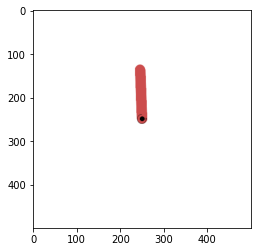

-247.3974781797497

In [10]:
test(play=True)